# GDSCv2 Analysis - Bortezomib (5 clusters)

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from sklearn.cluster import KMeans

In [4]:
from pyBasket.common import load_obj, save_obj
from pyBasket.model import get_patient_model_simple, get_patient_model_hierarchical
from pyBasket.model import get_patient_model_hierarchical_log_odds, get_patient_model_hierarchical_log_odds_nc
from pyBasket.clustering import get_cluster_df_by_basket, plot_PCA, get_patient_df
from pyBasket.preprocessing import select_rf, check_rf

# Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

ENSG00000000003.15  ENSG00000000005.6  ENSG00000000419.12  \
TGBC24TKB            3.842223          -5.465508            6.643472   
EGI-1                5.477477          -3.712215            5.685061   
TGBC1TKB             5.247886          -5.464387            6.443945   
ETK-1                5.772839          -5.669225            6.345230   
SW1710               3.891433          -6.720904            6.461246   
...                       ...                ...                 ...   
ASH-3                3.230687          -9.965784            6.793055   
KMH-2                2.644470          -9.965784            7.369643   
HTC-C3               4.297403          -9.965784            6.790183   
IHH-4                2.770616          -5.795143            5.490973   
HEC-1                4.511196          -4.535588            6.296627   

           ENSG00000000457.14  ENSG00000000460.17  ENSG00000000938.13  \
TGBC24TKB            2.413681            3.523928           -6.722421   
EGI-1                3.274900            3.243179           -4.146015   
TGBC1TKB             2.174270            4.884496           -3.860326   
ETK-1                2.088130            4.272358           -6.904595   
SW1710               2.432792            3.541814           -6.584625   
...                       ...                 ...                 ...   
ASH-3                2.174138            2.815748           -6.168741   
KMH-2                2.521319            4.211213           -9.965784   
HTC-C3               1.780538            2.229505           -2.115773   
IHH-4                3.801877            4.603189           -2.927377   
HEC-1                2.463557            4.079280           -6.010182   

           ENSG00000000971.16  ENSG00000001036.14  ENSG00000001084.13  \
TGBC24TKB            1.493328            5.312851            7.657224   
EGI-1                4.508079            4.801951            4.677299   
TGBC1TKB            -2.119720            6.585122            7.530231   
ETK-1                2.426256            6.914759            6.597911   
SW1710               4.976817            5.593969            4.455942   
...                       ...                 ...                 ...   
ASH-3                3.105009            4.966726            4.675848   
KMH-2                1.926462            5.212597            3.104173   
HTC-C3               3.557124            4.339450            4.492282   
IHH-4               -3.172772           -0.264386            4.179838   
HEC-1                0.860272            5.429501            5.651821   

           ENSG00000001167.14  ...  ENSG00000288436.1  ENSG00000288460.1  \
TGBC24TKB            4.241038  ...          -9.965784          -6.590911   
EGI-1                4.812610  ...          -5.393783          -6.552767   
TGBC1TKB             4.834777  ...          -3.459260          -9.965784   
ETK-1                4.163071  ...          -3.497535          -6.780472   
SW1710               5.065822  ...          -2.528606          -5.514698   
...                       ...  ...                ...                ...   
ASH-3                4.668331  ...          -9.965784          -9.965784   
KMH-2                3.763338  ...          -6.705062          -9.965784   
HTC-C3               4.175475  ...          -9.965784          -6.805531   
IHH-4                4.530007  ...          -2.538738          -5.954484   
HEC-1                3.993226  ...          -3.963675          -6.868090   

           ENSG00000288520.1  ENSG00000288529.1  ENSG00000288534.1  \
TGBC24TKB          -9.965784          -9.965784           3.498175   
EGI-1              -4.030988          -9.965784           2.821231   
TGBC1TKB           -6.932179          -9.965784           2.675651   
ETK-1              -3.047387          -9.965784           3.500665   
SW1710             -4.137394          -9.965784           3.020995   
...                      ...                ...            

Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

CNS/Brain  Bone  Prostate  Esophagus/Stomach  \
TGBC24TKB          0     0         0                  0   
EGI-1              0     0         0                  0   
TGBC1TKB           0     0         0                  0   
ETK-1              0     0         0                  0   
SW1710             0     0         0                  0   
...              ...   ...       ...                ...   
ASH-3              0     0         0                  0   
KMH-2              0     0         0                  0   
HTC-C3             0     0         0                  0   
IHH-4              0     0         0                  0   
HEC-1              0     0         0                  0   

           Bladder/Urinary Tract  Ovary/Fallopian Tube  Lymphoid  Kidney  \
TGBC24TKB                      0                     0         0       0   
EGI-1                          0                     0         0       0   
TGBC1TKB                       0                     0         0       0   
ETK-1                          0                     0         0       0   
SW1710                         1                     0         0       0   
...                          ...                   ...       ...     ...   
ASH-3                          0                     0         0       0   
KMH-2                          0                     0         0       0   
HTC-C3                         0                     0         0       0   
IHH-4                          0                     0         0       0   
HEC-1                          0                     0         0       0   

           Thyroid  Soft Tissue  ...  Uterus  Pancreas  Breast  Cervix  Bowel  \
TGBC24TKB        0            0  ...       0         0       0       0      0   
EGI-1            0            0  ...       0         0       0       0      0   
TGBC1TKB         0            0  ...       0         0       0       0      0   
ETK-1            0            0  ...       0         0       0       0      0   
SW1710           0            0  ...       0         0       0       0      0   
...            ...          ...  ...     ...       ...     ...     ...    ...   
ASH-3            1            0  ...       0         0       0       0      0   
KMH-2            1            0  ...       0         0       0       0      0   
HTC-C3           1            0  ...       0         0       0       0      0   
IHH-4            1            0  ...       0         0       0       0      0   
HEC-1            0            0  ...       1         0       0       0      0   

           Peripheral Nervous System  Liver  Biliary Tract  Other  \
TGBC24TKB                          0      0              1      0   
EGI-1                              0      0              1      0   
TGBC1TKB                           0      0              1      0   
ETK-1                              0      0              1      0   
SW1710                             0      0              0      0   
...                              ...    ...            ...    ...   
ASH-3                              0      0              0      0   
KMH-2                              0      0              0      0   
HTC-C3                             0      0              0      0   
IHH-4                              0      0              0      0   
HEC-1                              0      0              0      0   

           Ampulla of Vater  
TGBC24TKB                 0  
EGI-1                     0  
TGBC1TKB                  0  
ETK-1                     0  
SW1710                    0  
...                     ...  
ASH-3                     0  
KMH-2                     0  
HTC-C3                    0  
IHH-4                     0  
HEC-1                     0  

[446 rows x 25 columns]

In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

# Do PCA and colour by basket (tissues)

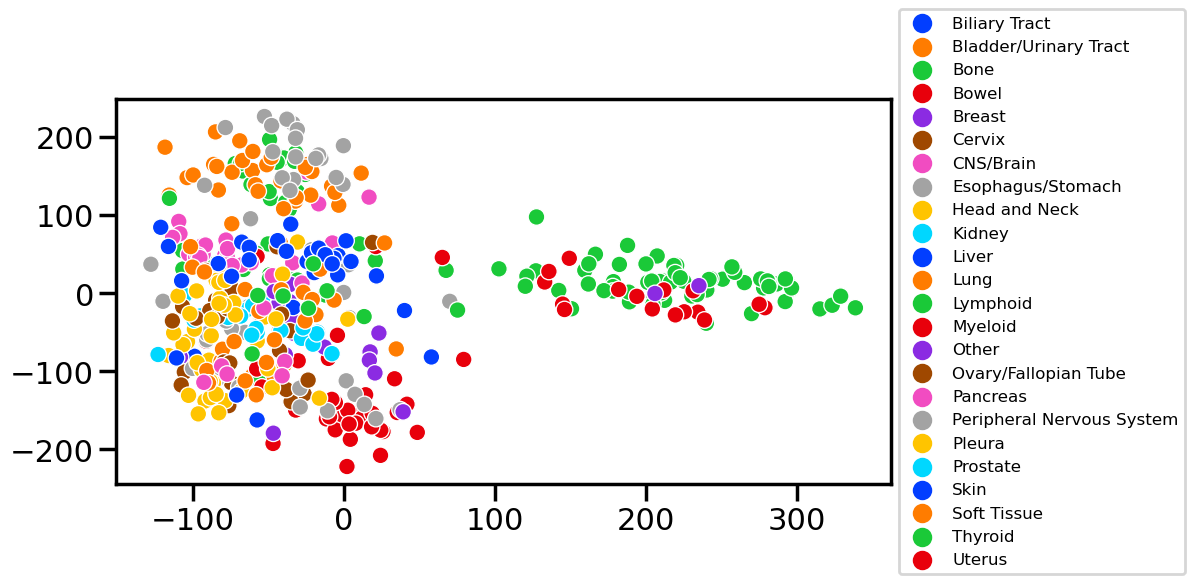

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535599 0.40877656 0.42098277]


In [10]:
_ = plot_PCA(expr_df, n_components=10, hue=tissues)

# Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

Bortezomib  Entinostat  Sirolimus  Docetaxel  Gemcitabine  \
143B             NaN         NaN        NaN        NaN          NaN   
201T             NaN         NaN        NaN        NaN          NaN   
22Rv1       0.184836    0.142503   0.304184   0.111977     0.596289   
23132/87    0.228235    0.121580   0.208475   0.232821     0.407328   
380              NaN         NaN        NaN        NaN          NaN   
...              ...         ...        ...        ...          ...   
YH-13       0.174638    0.019992   0.157624   0.211467     0.359880   
YKG-1            NaN         NaN        NaN        NaN          NaN   
YMB-1-E          NaN         NaN        NaN        NaN          NaN   
YT          0.230123         NaN   0.212004   0.113564     0.666782   
ZR-75-30    0.029824    0.036509   0.110687   0.061314     0.141155   

          Crizotinib  Lapatinib  Vorinostat  Erlotinib  Paclitaxel  Pictilisib  
143B             NaN        NaN         NaN        NaN         NaN         NaN  
201T             NaN        NaN         NaN        NaN         NaN         NaN  
22Rv1       0.077036   0.048663    0.240865   0.069736    0.015539    0.254125  
23132/87    0.018921   0.172438    0.235145   0.124366    0.025982    0.431203  
380              NaN        NaN         NaN        NaN         NaN         NaN  
...              ...        ...         ...        ...         ...         ...  
YH-13       0.008977   0.069979    0.144077   0.108331    0.087400    0.349741  
YKG-1            NaN        NaN         NaN        NaN         NaN         NaN  
YMB-1-E          NaN        NaN         NaN        NaN         NaN         NaN  
YT               NaN   0.084477    0.235547   0.000000    0.000000    0.172903  
ZR-75-30    0.000000   0.402298    0.066816   0.059044    0.000000    0.150910  

[1104 rows x 11 columns]

In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

## Collect the samples and responses for the drug

In [13]:
drug_name = 'Bortezomib'

In [14]:
samples = tissue_df.index.values
response_dict = response_df[drug_name].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [15]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

tissues    samples  responses
0            Biliary Tract  TGBC24TKB   0.046804
1            Biliary Tract      EGI-1   0.172105
2            Biliary Tract   TGBC1TKB   0.180130
3            Biliary Tract      ETK-1   0.175669
4    Bladder/Urinary Tract     SW1710   0.235879
..                     ...        ...        ...
441                Thyroid      ASH-3   0.239005
442                Thyroid      KMH-2        NaN
443                Thyroid     HTC-C3   0.296591
444                Thyroid      IHH-4   0.099876
445                 Uterus      HEC-1   0.175794

[446 rows x 3 columns]

## Drop all the NaN responses

In [16]:
df = df.dropna(subset=['responses'])
df

tissues    samples  responses
0            Biliary Tract  TGBC24TKB   0.046804
1            Biliary Tract      EGI-1   0.172105
2            Biliary Tract   TGBC1TKB   0.180130
3            Biliary Tract      ETK-1   0.175669
4    Bladder/Urinary Tract     SW1710   0.235879
..                     ...        ...        ...
440                Thyroid        WRO   0.079241
441                Thyroid      ASH-3   0.239005
443                Thyroid     HTC-C3   0.296591
444                Thyroid      IHH-4   0.099876
445                 Uterus      HEC-1   0.175794

[299 rows x 3 columns]

In [17]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [18]:
df.groupby('tissues').count()

samples  responses
tissues                                      
Biliary Tract                    4          4
Bladder/Urinary Tract            5          5
Bone                            25         25
Bowel                           28         28
Breast                          11         11
CNS/Brain                       14         14
Cervix                          13         13
Esophagus/Stomach               19         19
Head and Neck                   16         16
Kidney                           5          5
Liver                            2          2
Lung                            24         24
Lymphoid                        53         53
Myeloid                         12         12
Other                            3          3
Ovary/Fallopian Tube            10         10
Pancreas                         5          5
Peripheral Nervous System       15         15
Pleura                          10         10
Prostate                         2          2
Skin                             8          8
Soft Tissue                      7          7
Thyroid                          7          7
Uterus                           1          1

In [19]:
df['responses'].max(), df['responses'].min()

(0.441171871256905, 0.0066721853284744)

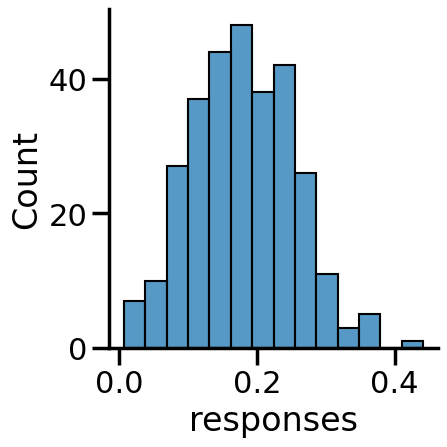

In [20]:
sns.displot(df['responses'])

In [21]:
df['responses'].mean(), df['responses'].median()

(0.17974956979291523, 0.17579447398293)

# Select baskets for analysis

Select some baskets

In [22]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

Use all baskets

In [23]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [24]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

tissues    samples  responses
0            Biliary Tract  TGBC24TKB   0.046804
1            Biliary Tract      EGI-1   0.172105
2            Biliary Tract   TGBC1TKB   0.180130
3            Biliary Tract      ETK-1   0.175669
4    Bladder/Urinary Tract     SW1710   0.235879
..                     ...        ...        ...
294                Thyroid        WRO   0.079241
295                Thyroid      ASH-3   0.239005
296                Thyroid     HTC-C3   0.296591
297                Thyroid      IHH-4   0.099876
298                 Uterus      HEC-1   0.175794

[299 rows x 3 columns]

In [25]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((299, 19957), (446, 19957))

In [26]:
expr_df_filtered

ENSG00000000003.15  ENSG00000000005.6  ENSG00000000419.12  \
TGBC24TKB            3.842223          -5.465508            6.643472   
EGI-1                5.477477          -3.712215            5.685061   
TGBC1TKB             5.247886          -5.464387            6.443945   
ETK-1                5.772839          -5.669225            6.345230   
SW1710               3.891433          -6.720904            6.461246   
...                       ...                ...                 ...   
WRO                  3.205753          -9.965784            7.307272   
ASH-3                3.230687          -9.965784            6.793055   
HTC-C3               4.297403          -9.965784            6.790183   
IHH-4                2.770616          -5.795143            5.490973   
HEC-1                4.511196          -4.535588            6.296627   

           ENSG00000000457.14  ENSG00000000460.17  ENSG00000000938.13  \
TGBC24TKB            2.413681            3.523928           -6.722421   
EGI-1                3.274900            3.243179           -4.146015   
TGBC1TKB             2.174270            4.884496           -3.860326   
ETK-1                2.088130            4.272358           -6.904595   
SW1710               2.432792            3.541814           -6.584625   
...                       ...                 ...                 ...   
WRO                 -0.607968            0.481533           -9.965784   
ASH-3                2.174138            2.815748           -6.168741   
HTC-C3               1.780538            2.229505           -2.115773   
IHH-4                3.801877            4.603189           -2.927377   
HEC-1                2.463557            4.079280           -6.010182   

           ENSG00000000971.16  ENSG00000001036.14  ENSG00000001084.13  \
TGBC24TKB            1.493328            5.312851            7.657224   
EGI-1                4.508079            4.801951            4.677299   
TGBC1TKB            -2.119720            6.585122            7.530231   
ETK-1                2.426256            6.914759            6.597911   
SW1710               4.976817            5.593969            4.455942   
...                       ...                 ...                 ...   
WRO                  0.725387            5.847553            4.118905   
ASH-3                3.105009            4.966726            4.675848   
HTC-C3               3.557124            4.339450            4.492282   
IHH-4               -3.172772           -0.264386            4.179838   
HEC-1                0.860272            5.429501            5.651821   

           ENSG00000001167.14  ...  ENSG00000288436.1  ENSG00000288460.1  \
TGBC24TKB            4.241038  ...          -9.965784          -6.590911   
EGI-1                4.812610  ...          -5.393783          -6.552767   
TGBC1TKB             4.834777  ...          -3.459260          -9.965784   
ETK-1                4.163071  ...          -3.497535          -6.780472   
SW1710               5.065822  ...          -2.528606          -5.514698   
...                       ...  ...                ...                ...   
WRO                  4.821918  ...          -6.475129          -6.749269   
ASH-3                4.668331  ...          -9.965784          -9.965784   
HTC-C3               4.175475  ...          -9.965784          -6.805531   
IHH-4                4.530007  ...          -2.538738          -5.954484   
HEC-1                3.993226  ...          -3.963675          -6.868090   

           ENSG00000288520.1  ENSG00000288529.1  ENSG00000288534.1  \
TGBC24TKB          -9.965784          -9.965784           3.498175   
EGI-1              -4.030988          -9.965784           2.821231   
TGBC1TKB           -6.932179          -9.965784           2.675651   
ETK-1              -3.047387          -9.965784           3.500665   
SW1710             -4.137394          -9.965784           3.020995   
...                      ...                ...            

In [27]:
drug_response = df_filtered.set_index('samples').drop(columns=['tissues'])
drug_response

responses
samples             
TGBC24TKB   0.046804
EGI-1       0.172105
TGBC1TKB    0.180130
ETK-1       0.175669
SW1710      0.235879
...              ...
WRO         0.079241
ASH-3       0.239005
HTC-C3      0.296591
IHH-4       0.099876
HEC-1       0.175794

[299 rows x 1 columns]

## Feature selection using random forest

In [28]:
try: # try to load previously selected features
    fname = os.path.join('results', '%s_expr_df_selected.p' % drug_name)
    expr_df_selected = load_obj(fname)
    
except FileNotFoundError: # if not found, then re-run feature selection
    expr_df_selected = select_rf(expr_df_filtered, drug_response, n_splits=5, percentile_threshold=90, top_genes=500)
    save_obj(expr_df_selected, fname)

In [29]:
check_rf(expr_df_selected, drug_response, test_size=0.2)

Test set results using selected features:
MSE: 0.0030170462490361925
R^2: 0.29532261134791493


## Do PCA again on these samples

Before feature selection (using all 19957 transcripts)

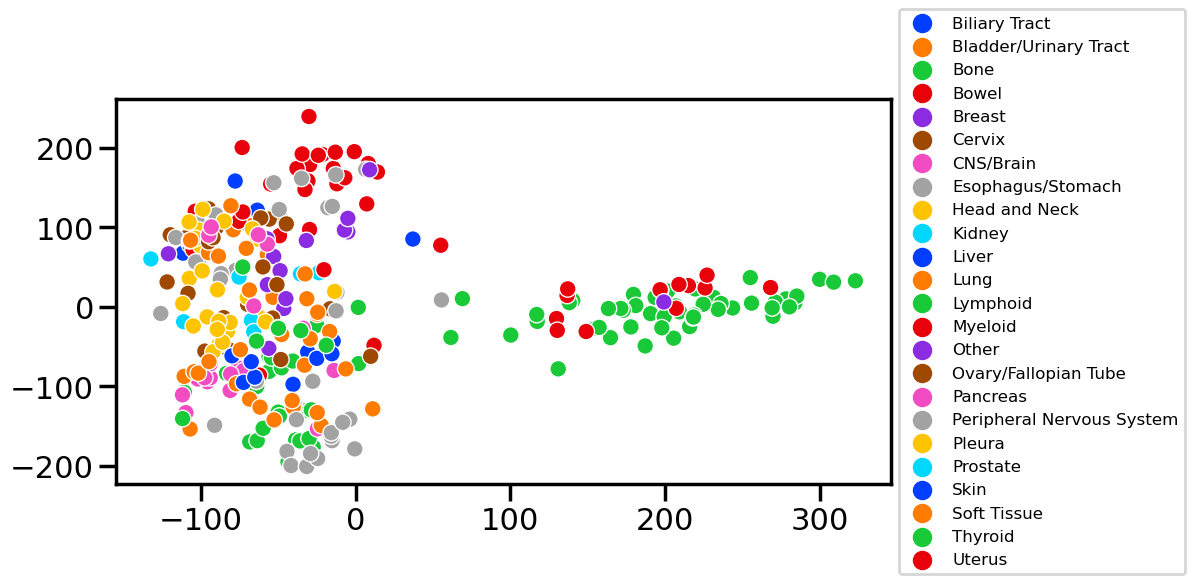

PCA explained variance [0.13785045 0.22932835 0.28970507 0.32243163 0.34542491 0.36526569
 0.38060368 0.39520107 0.40855166 0.42052912]


In [30]:
pc1, pc2 = plot_PCA(expr_df_filtered, n_components=10, hue=df_filtered['tissues'].values)

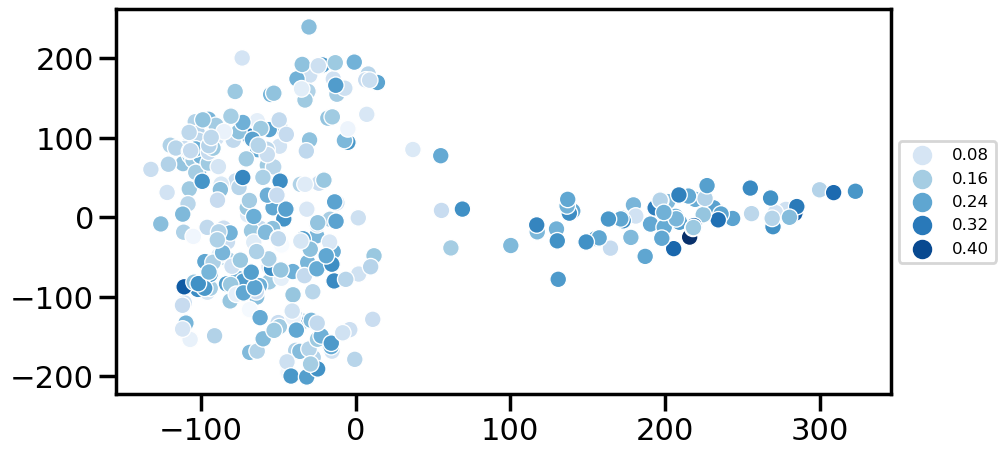

In [31]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

After feature selection (using 500 transcripts)

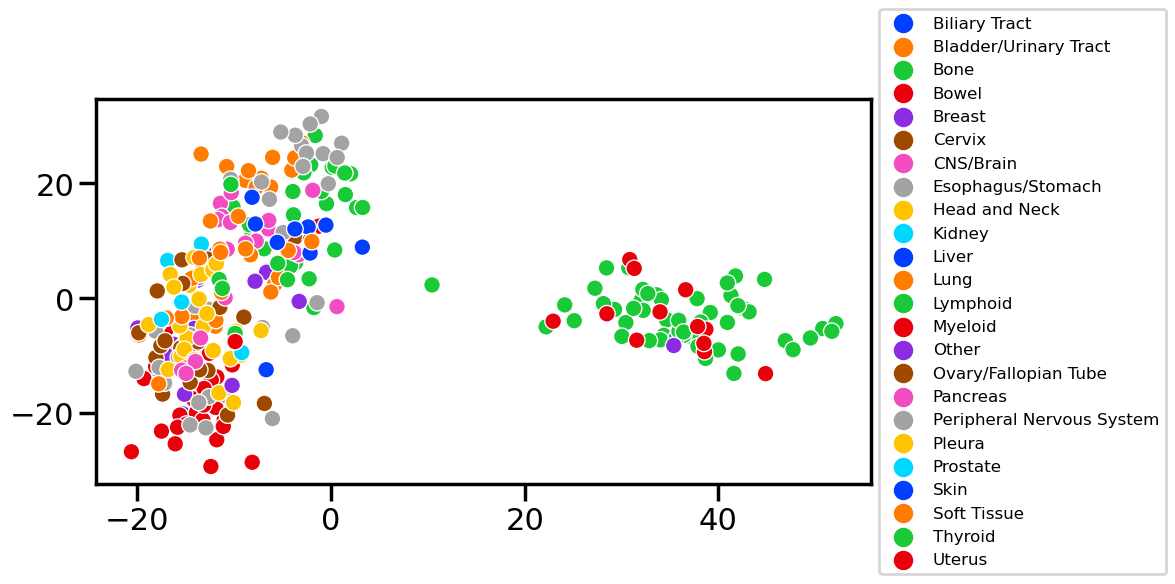

PCA explained variance [0.19778186 0.27908323 0.32775324 0.36747064 0.39191717 0.41425441
 0.43448596 0.45207794 0.46896129 0.48461134]


In [32]:
pc1, pc2 = plot_PCA(expr_df_selected, n_components=10, hue=df_filtered['tissues'].values)

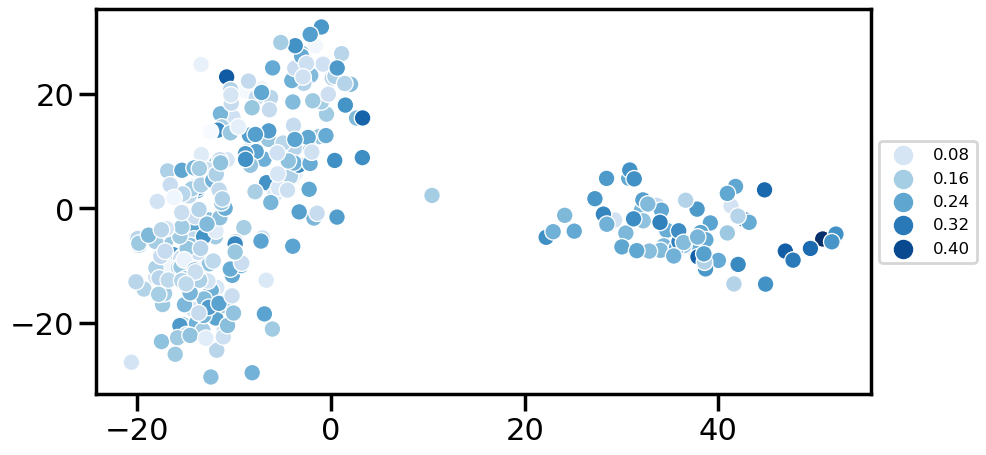

In [33]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1, y=pc2, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

# Try clustering

In [34]:
expr_df_selected.shape

(299, 500)

In [35]:
classes = df_filtered.set_index('samples')
classes

tissues  responses
samples                                    
TGBC24TKB          Biliary Tract   0.046804
EGI-1              Biliary Tract   0.172105
TGBC1TKB           Biliary Tract   0.180130
ETK-1              Biliary Tract   0.175669
SW1710     Bladder/Urinary Tract   0.235879
...                          ...        ...
WRO                      Thyroid   0.079241
ASH-3                    Thyroid   0.239005
HTC-C3                   Thyroid   0.296591
IHH-4                    Thyroid   0.099876
HEC-1                     Uterus   0.175794

[299 rows x 2 columns]

In [36]:
C = 5

In [37]:
kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_selected)

cluster_labels = kmeans.labels_
cluster_labels

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0,
       2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4,
       4, 4, 4, 1, 4, 4, 4, 4, 0, 2, 4, 4, 1, 4, 4, 4, 4, 4, 1, 1, 1, 1,
       1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1, 1, 1, 4, 4, 1, 1,
       4, 4, 1, 1, 4, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 4, 1, 0, 0, 4, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 4, 3, 1, 1, 0, 0, 1, 0, 2, 1,
       0, 1, 1, 4, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 4], dtyp

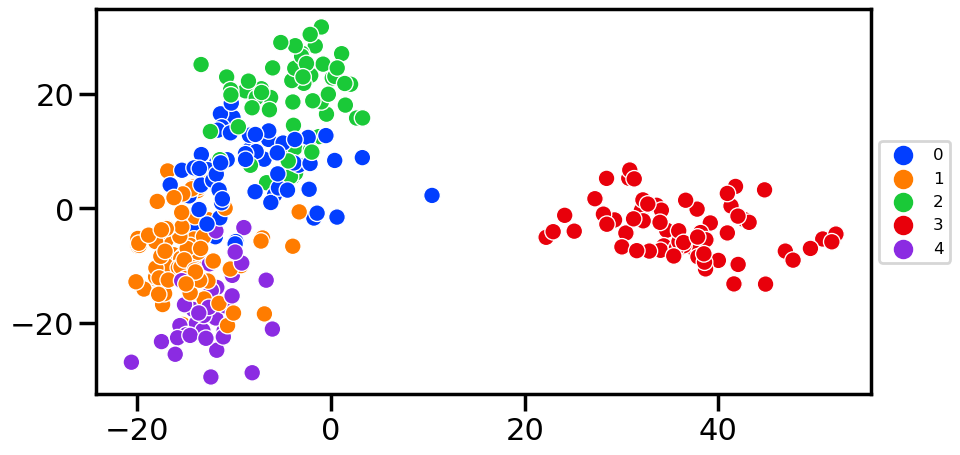

PCA explained variance [0.19778186 0.27908323 0.32775324 0.36747064 0.39191717 0.41425441
 0.43448596 0.45207794 0.46896129 0.48461134]


In [38]:
_ = plot_PCA(expr_df_selected, n_components=10, hue=cluster_labels)

# Run basket trial analysis

In [39]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [40]:
K = len(basket_names)
K, C

(24, 5)

Create clustering dataframe

In [41]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(299, 299)

In [42]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels, normalise=False)
cluster_df

sk_0  sk_1  sk_2  sk_3  sk_4
Biliary Tract                 0     4     0     0     0
Bladder/Urinary Tract         3     2     0     0     0
Bone                          7     0    18     0     0
Bowel                         1     4     1     0    22
Breast                        0     9     1     0     1
CNS/Brain                    13     0     1     0     0
Cervix                        0    11     1     0     1
Esophagus/Stomach             1    12     0     0     6
Head and Neck                 2    14     0     0     0
Kidney                        2     2     0     0     1
Liver                         1     0     0     0     1
Lung                          1     6    16     0     1
Lymphoid                      1     0     0    52     0
Myeloid                       0     0     0    12     0
Other                         1     0     0     1     1
Ovary/Fallopian Tube          4     5     1     0     0
Pancreas                      0     4     0     0     1
Peripheral Nervous System     1     0    14     0     0
Pleura                        7     3     0     0     0
Prostate                      0     2     0     0     0
Skin                          7     0     1     0     0
Soft Tissue                   6     0     1     0     0
Thyroid                       6     0     1     0     0
Uterus                        0     0     0     0     1

<AxesSubplot: >

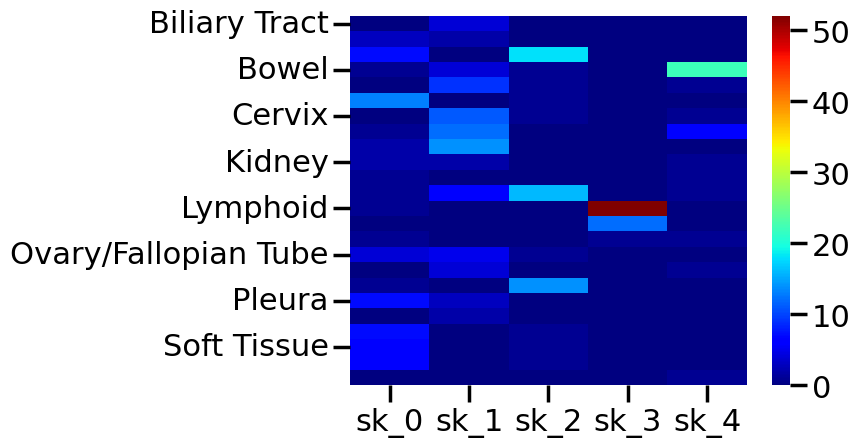

In [43]:
sns.heatmap(cluster_df, cmap='jet')

## Prepare patient data

In [44]:
patient_df = get_patient_df(df_filtered, cluster_labels)

In [45]:
patient_df

tissues  responses  basket_number  cluster_number  \
samples                                                                      
TGBC24TKB          Biliary Tract   0.046804              0               1   
EGI-1              Biliary Tract   0.172105              0               1   
TGBC1TKB           Biliary Tract   0.180130              0               1   
ETK-1              Biliary Tract   0.175669              0               1   
SW1710     Bladder/Urinary Tract   0.235879              1               0   
...                          ...        ...            ...             ...   
WRO                      Thyroid   0.079241             22               0   
ASH-3                    Thyroid   0.239005             22               0   
HTC-C3                   Thyroid   0.296591             22               0   
IHH-4                    Thyroid   0.099876             22               0   
HEC-1                     Uterus   0.175794             23               4   

           responsive  
samples                
TGBC24TKB           1  
EGI-1               1  
TGBC1TKB            0  
ETK-1               1  
SW1710              0  
...               ...  
WRO                 1  
ASH-3               0  
HTC-C3              0  
IHH-4               1  
HEC-1               0  

[299 rows x 5 columns]

## Define models

No. of samples to collect before and after burn-in during MCMC.

In [46]:
n_burn_in = int(1E4)
n_sample = int(1E4)
target_accept = 0.99

### Simple model

In [47]:
model_s = get_patient_model_simple(patient_df)

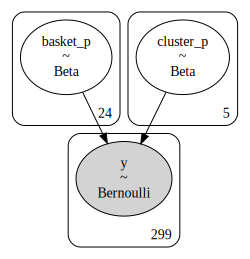

In [48]:
pm.model_to_graphviz(model_s)

In [49]:
with model_s:
    trace_s = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_p, cluster_p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 49 seconds.


In [50]:
az.summary(trace_s).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
basket_p[0]   0.46  0.15    0.19     0.73        0.0      0.0   75858.0   
basket_p[1]   0.35  0.14    0.10     0.59        0.0      0.0   85285.0   
basket_p[2]   0.54  0.09    0.36     0.72        0.0      0.0   79326.0   
basket_p[3]   0.54  0.10    0.36     0.71        0.0      0.0   78248.0   
basket_p[4]   0.41  0.12    0.19     0.62        0.0      0.0   79565.0   
basket_p[5]   0.56  0.11    0.36     0.76        0.0      0.0   70539.0   
basket_p[6]   0.36  0.11    0.16     0.57        0.0      0.0   74699.0   
basket_p[7]   0.57  0.10    0.38     0.76        0.0      0.0   80235.0   
basket_p[8]   0.45  0.10    0.26     0.65        0.0      0.0   80171.0   
basket_p[9]   0.58  0.14    0.34     0.84        0.0      0.0   76047.0   
basket_p[10]  0.34  0.15    0.07     0.62        0.0      0.0   77839.0   
basket_p[11]  0.71  0.09    0.55     0.87        0.0      0.0   77615.0   
basket_p[12]  0.28  0.10    0.12     0.47        0.0      0.0   48935.0   
basket_p[13]  0.28  0.12    0.07     0.51        0.0      0.0   69961.0   
basket_p[14]  0.42  0.15    0.14     0.71        0.0      0.0   87061.0   
basket_p[15]  0.55  0.12    0.33     0.78        0.0      0.0   77586.0   
basket_p[16]  0.50  0.14    0.24     0.76        0.0      0.0   78589.0   
basket_p[17]  0.53  0.11    0.32     0.73        0.0      0.0   75570.0   
basket_p[18]  0.50  0.12    0.26     0.71        0.0      0.0   80374.0   
basket_p[19]  0.44  0.16    0.16     0.73        0.0      0.0   85998.0   
basket_p[20]  0.22  0.11    0.03     0.41        0.0      0.0   73732.0   
basket_p[21]  0.45  0.14    0.20     0.70        0.0      0.0   79070.0   
basket_p[22]  0.52  0.13    0.27     0.77        0.0      0.0   77670.0   
basket_p[23]  0.26  0.15    0.02     0.53        0.0      0.0   77097.0   
cluster_p[0]  0.88  0.07    0.75     0.99        0.0      0.0   56825.0   
cluster_p[1]  0.95  0.04    0.88     1.00        0.0      0.0   59366.0   
cluster_p[2]  0.90  0.06    0.80     0.99        0.0      0.0   61798.0   
cluster_p[3]  0.64  0.16    0.36     0.93        0.0      0.0   44659.0   
cluster_p[4]  0.86  0.08    0.71     0.99        0.0      0.0   60414.0   

              ess_tail  r_hat  
basket_p[0]    28031.0    1.0  
basket_p[1]    29101.0    1.0  
basket_p[2]    29442.0    1.0  
basket_p[3]    30492.0    1.0  
basket_p[4]    29374.0    1.0  
basket_p[5]    27666.0    1.0  
basket_p[6]    29248.0    1.0  
basket_p[7]    28850.0    1.0  
basket_p[8]    28554.0    1.0  
basket_p[9]    29833.0    1.0  
basket_p[10]   28618.0    1.0  
basket_p[11]   28063.0    1.0  
basket_p[12]   31427.0    1.0  
basket_p[13]   31763.0    1.0  
basket_p[14]   28488.0    1.0  
basket_p[15]   29666.0    1.0  
basket_p[16]   28817.0    1.0  
basket_p[17]   29410.0    1.0  
basket_p[18]   27573.0    1.0  
basket_p[19]   29021.0    1.0  
basket_p[20]   28769.0    1.0  
basket_p[21]   28710.0    1.0  
basket_p[22]   26206.0    1.0  
basket_p[23]   25953.0    1.0  
cluster_p[0]   26614.0    1.0  
cluster_p[1]   27393.0    1.0  
cluster_p[2]   27550.0    1.0  
cluster_p[3]   32259.0    1.0  
cluster_p[4]   28471.0    1.0

array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

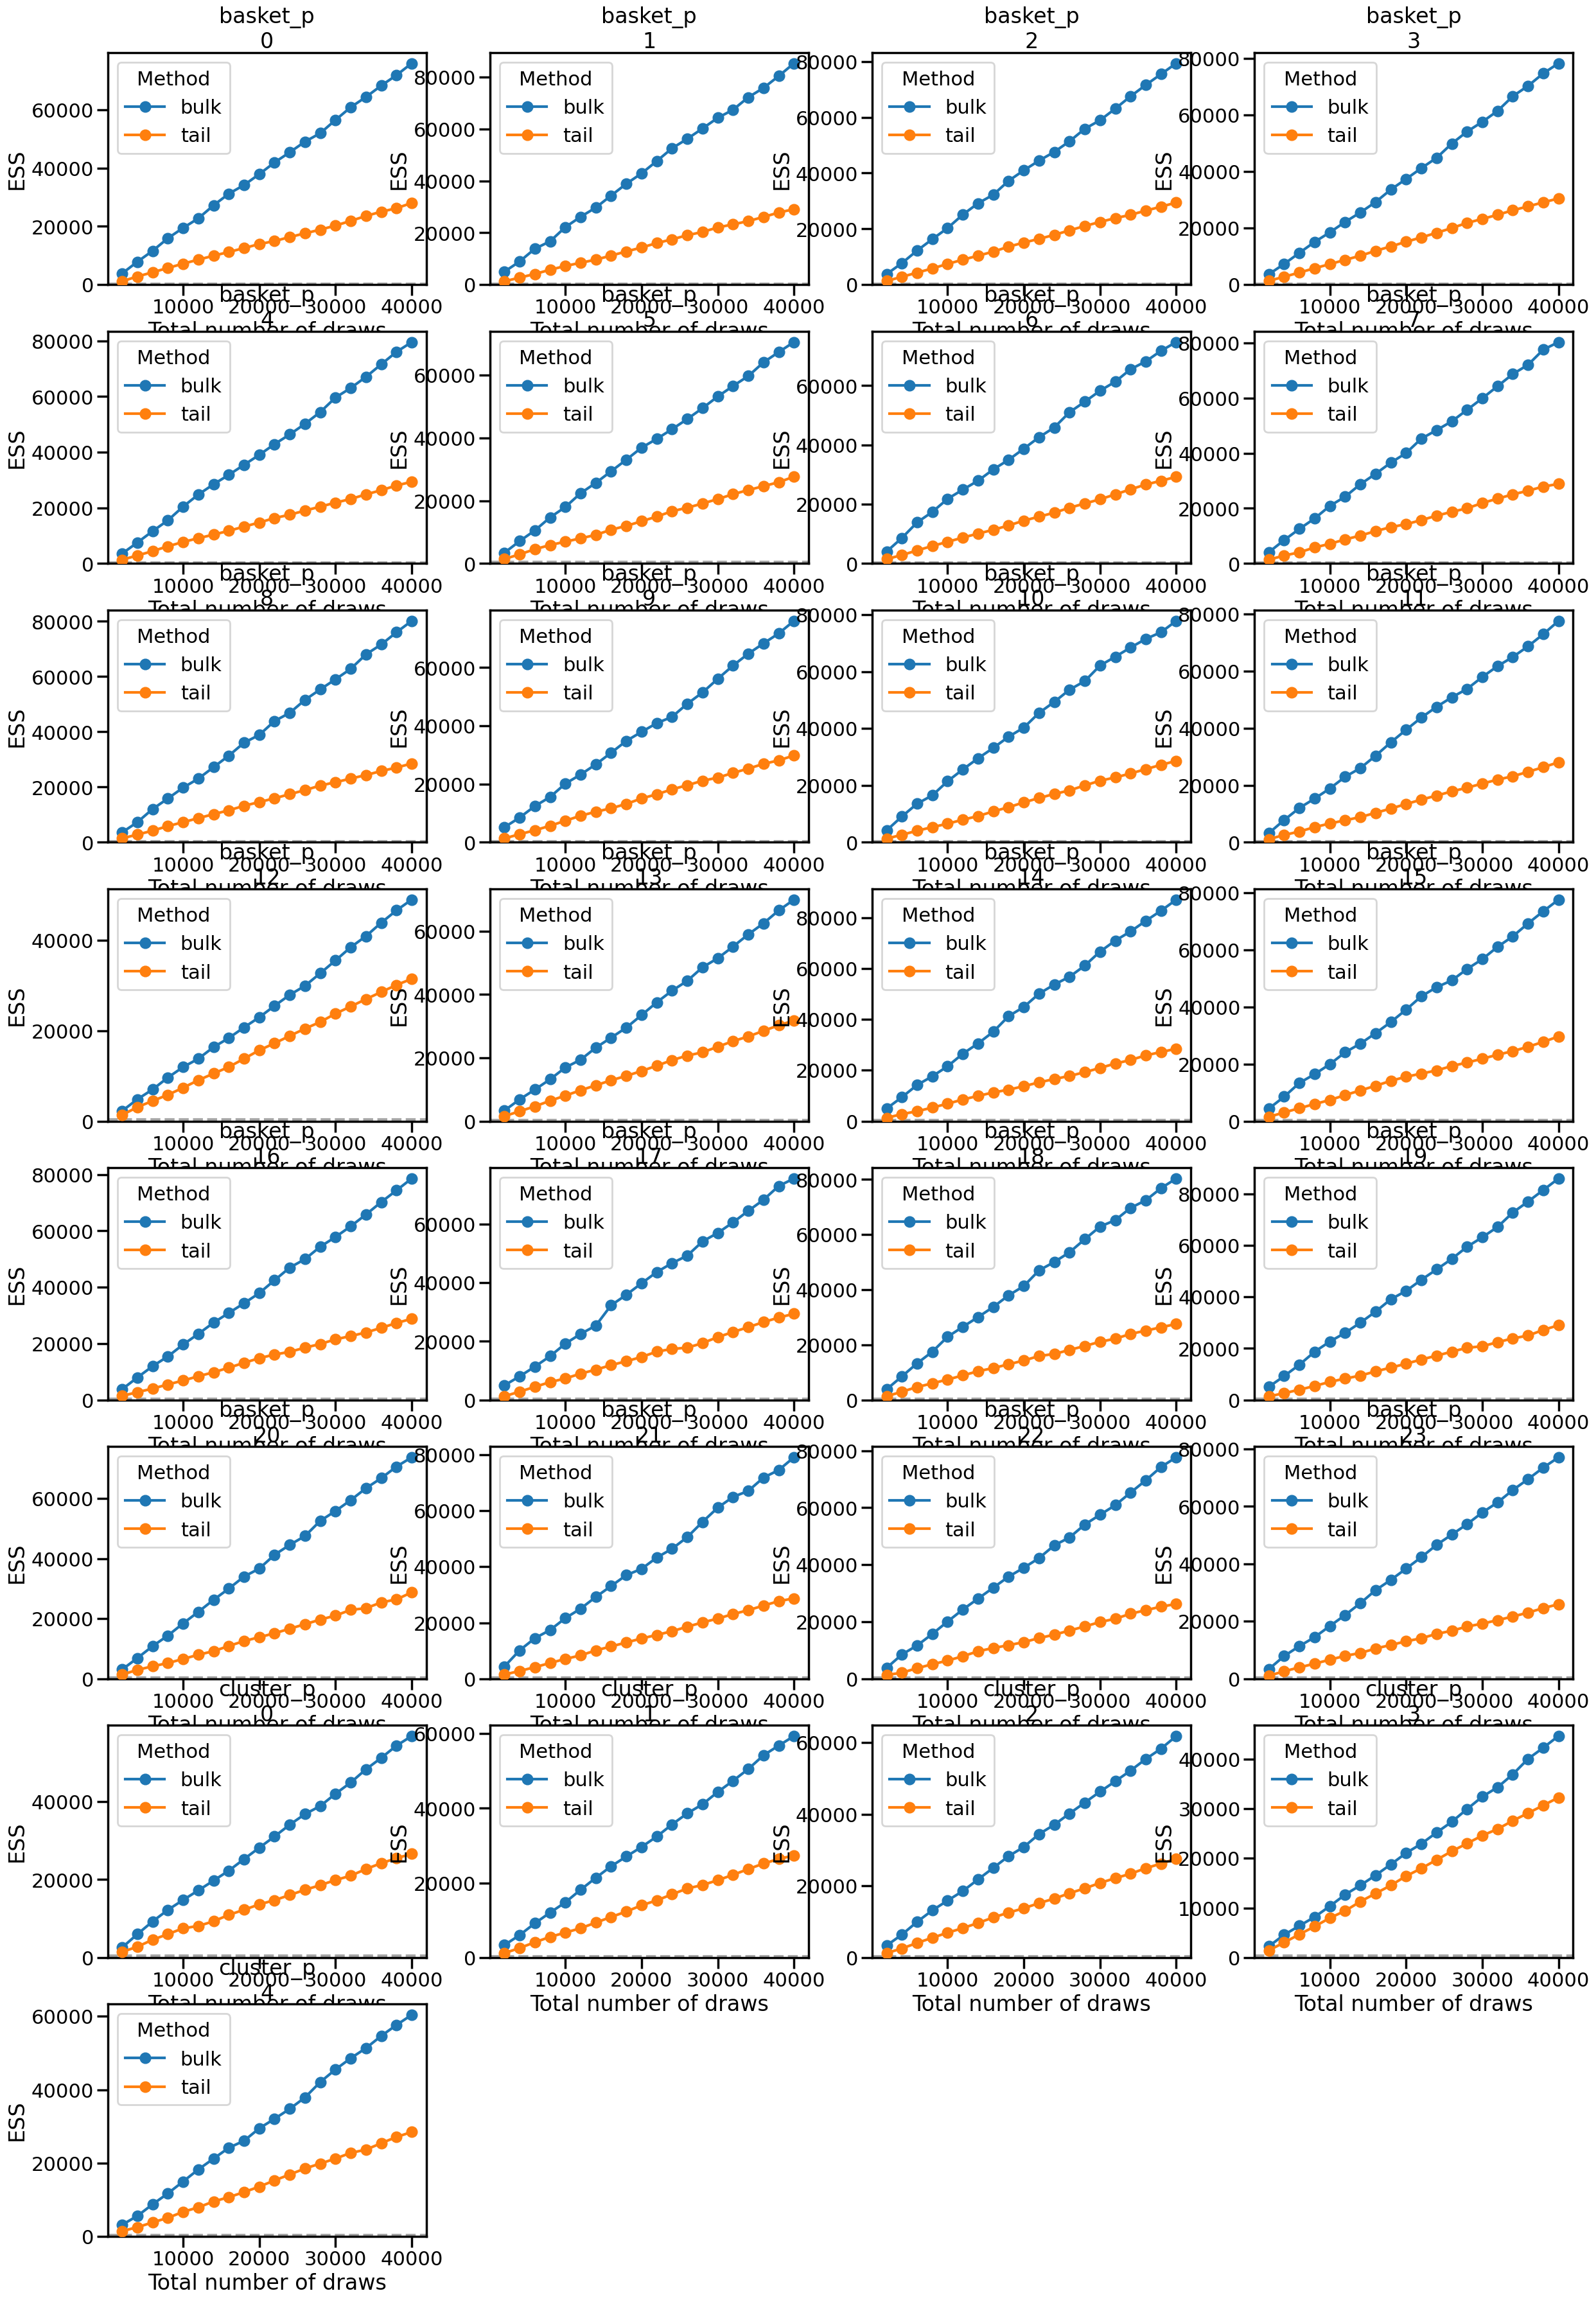

In [51]:
az.plot_ess(
    trace_s, kind="evolution", var_names=['basket_p', 'cluster_p']
)

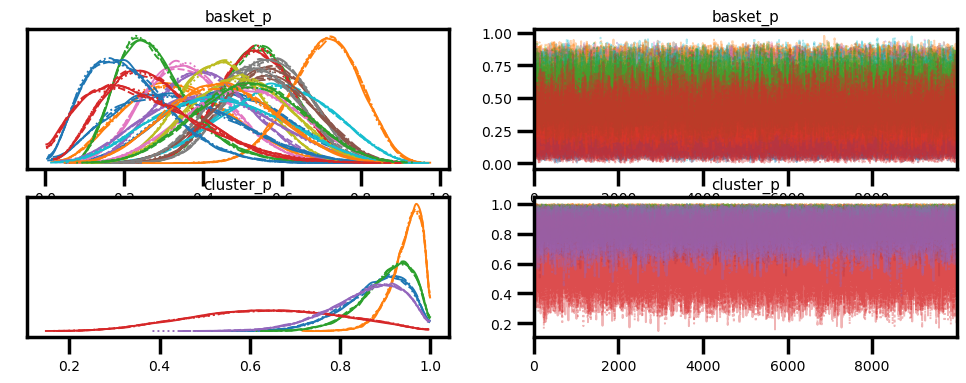

In [52]:
az.plot_trace(trace_s, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

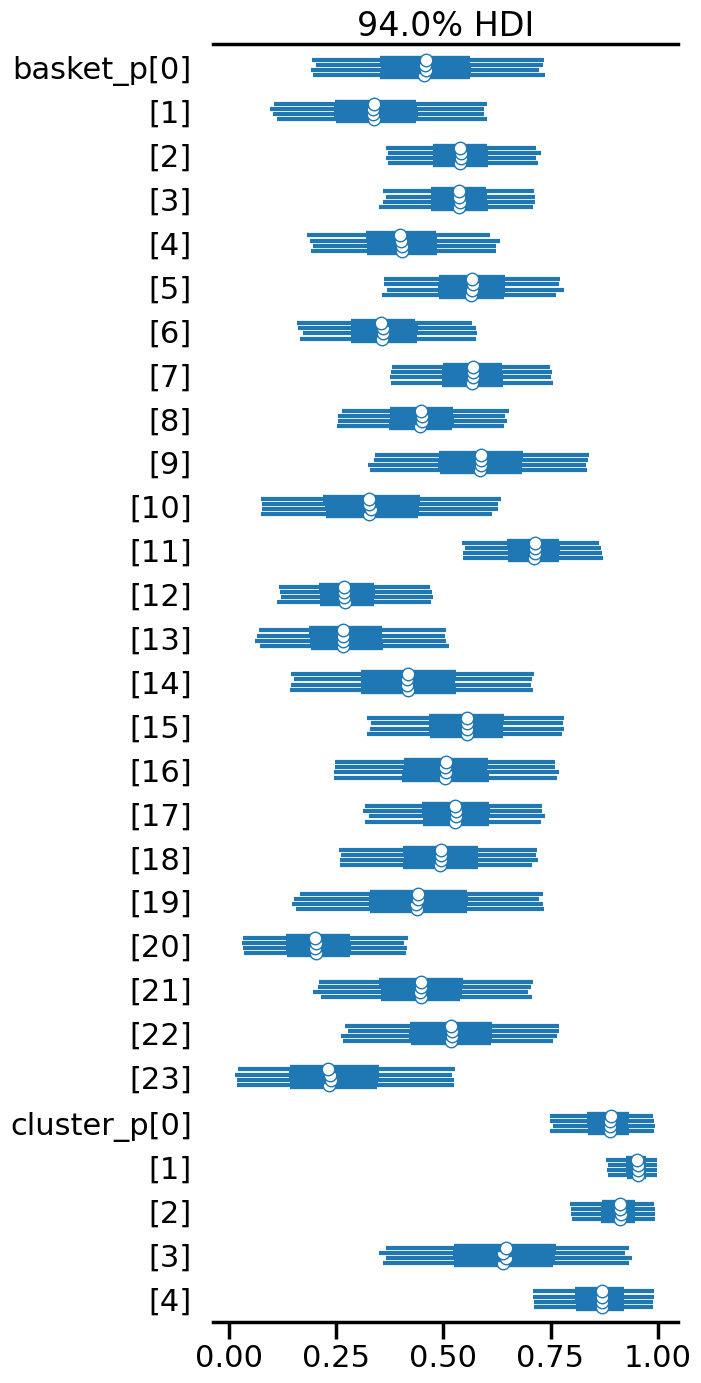

In [53]:
az.plot_forest(trace_s, var_names=['basket_p', 'cluster_p'])

In [54]:
stacked_s = az.extract(trace_s)

In [55]:
inferred_basket_p = stacked_s.basket_p.values[:, 0]

In [56]:
inferred_cluster_p = stacked_s.cluster_p.values[:, 0]

In [57]:
inferred_mat_s = np.outer(inferred_basket_p, inferred_cluster_p)

### Hierarchical model 1

This hierarchical model suffers from a lot of divergences. See:
- https://discourse.pymc.io/t/non-centered-parameterization-of-a-beta-distribution/6872/7
- https://stats.stackexchange.com/questions/67443/does-the-beta-distribution-have-a-conjugate-prior

In [58]:
model_h1 = get_patient_model_hierarchical(patient_df)

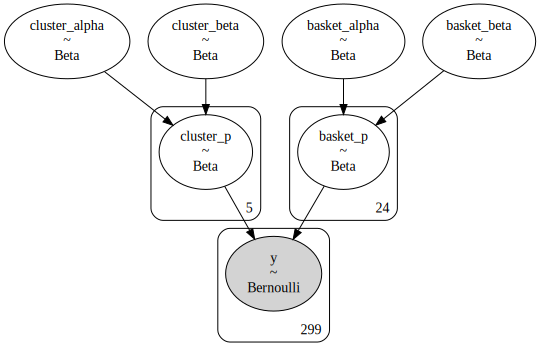

In [59]:
pm.model_to_graphviz(model_h1)

In [60]:
with model_h1:
    trace_h1 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basket_alpha, basket_beta, cluster_alpha, cluster_beta, basket_p, cluster_p]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 250 seconds.
There were 1517 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3797 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3905, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1590 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1662 divergences after tuning. Increase `target_accept` or reparameterize.


In [61]:
az.summary(trace_h1).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
basket_alpha   0.83  0.14    0.56     1.00       0.00      0.0    6272.0   
basket_beta    0.22  0.14    0.05     0.49       0.01      0.0     696.0   
cluster_alpha  0.74  0.18    0.41     1.00       0.00      0.0   12866.0   
cluster_beta   0.68  0.21    0.33     1.00       0.00      0.0    3212.0   
basket_p[0]    0.91  0.14    0.62     1.00       0.00      0.0    2139.0   
basket_p[1]    0.81  0.24    0.35     1.00       0.00      0.0    2007.0   
basket_p[2]    0.92  0.12    0.67     1.00       0.00      0.0    1467.0   
basket_p[3]    0.87  0.16    0.56     1.00       0.00      0.0    1090.0   
basket_p[4]    0.75  0.22    0.38     1.00       0.00      0.0    1804.0   
basket_p[5]    0.91  0.12    0.66     1.00       0.00      0.0    1749.0   
basket_p[6]    0.80  0.22    0.40     1.00       0.00      0.0    2023.0   
basket_p[7]    0.90  0.13    0.64     1.00       0.00      0.0    1200.0   
basket_p[8]    0.74  0.20    0.43     1.00       0.00      0.0    1588.0   
basket_p[9]    0.96  0.07    0.83     1.00       0.00      0.0    2339.0   
basket_p[10]   0.86  0.21    0.40     1.00       0.00      0.0    2392.0   
basket_p[11]   0.98  0.05    0.88     1.00       0.00      0.0    1946.0   
basket_p[12]   0.90  0.16    0.54     1.00       0.00      0.0    2210.0   
basket_p[13]   0.87  0.20    0.44     1.00       0.00      0.0    1983.0   
basket_p[14]   0.93  0.13    0.66     1.00       0.00      0.0    2634.0   
basket_p[15]   0.95  0.09    0.78     1.00       0.00      0.0    2275.0   
basket_p[16]   0.93  0.12    0.69     1.00       0.00      0.0    2032.0   
basket_p[17]   0.91  0.13    0.64     1.00       0.00      0.0    1809.0   
basket_p[18]   0.92  0.12    0.66     1.00       0.00      0.0    1888.0   
basket_p[19]   0.93  0.13    0.67     1.00       0.00      0.0    2536.0   
basket_p[20]   0.46  0.30    0.08     1.00       0.01      0.0    2865.0   
basket_p[21]   0.92  0.13    0.64     1.00       0.00      0.0    2328.0   
basket_p[22]   0.95  0.10    0.76     1.00       0.00      0.0    2207.0   
basket_p[23]   0.69  0.34    0.07     1.00       0.01      0.0    2796.0   
cluster_p[0]   0.56  0.10    0.39     0.74       0.00      0.0    1868.0   
cluster_p[1]   0.78  0.09    0.65     1.00       0.00      0.0    1078.0   
cluster_p[2]   0.69  0.09    0.53     0.86       0.00      0.0    2003.0   
cluster_p[3]   0.19  0.08    0.08     0.32       0.00      0.0    5915.0   
cluster_p[4]   0.65  0.14    0.46     1.00       0.00      0.0    1232.0   

               ess_tail  r_hat  
basket_alpha     6958.0   1.00  
basket_beta      1031.0   1.01  
cluster_alpha   11122.0   1.00  
cluster_beta     2685.0   1.00  
basket_p[0]      5883.0   1.00  
basket_p[1]      3230.0   1.00  
basket_p[2]      3344.0   1.01  
basket_p[3]      2543.0   1.01  
basket_p[4]      2594.0   1.00  
basket_p[5]      4501.0   1.00  
basket_p[6]      4255.0   1.00  
basket_p[7]      2783.0   1.01  
basket_p[8]      2101.0   1.00  
basket_p[9]      3541.0   1.00  
basket_p[10]     3747.0   1.00  
basket_p[11]     2867.0   1.00  
basket_p[12]     4009.0   1.00  
basket_p[13]     2358.0   1.00  
basket_p[14]     3894.0   1.00  
basket_p[15]     5789.0   1.00  
basket_p[16]     5096.0   1.00  
basket_p[17]     3828.0   1.00  
basket_p[18]     4683.0   1.00  
basket_p[19]     3940.0   1.00  
basket_p[20]     1519.0   1.00  
basket_p[21]     4174.0   1.00  
basket_p[22]     3520.0   1.00  
basket_p[23]     4018.0   1.00  
cluster_p[0]     1817.0   1.00  
cluster_p[1]      907.0   1.01  
cluster_p[2]     1212.0   1.00  
cluster_p[3]     5010.0   1.00  
cluster_p[4]      866.0   1.01

array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

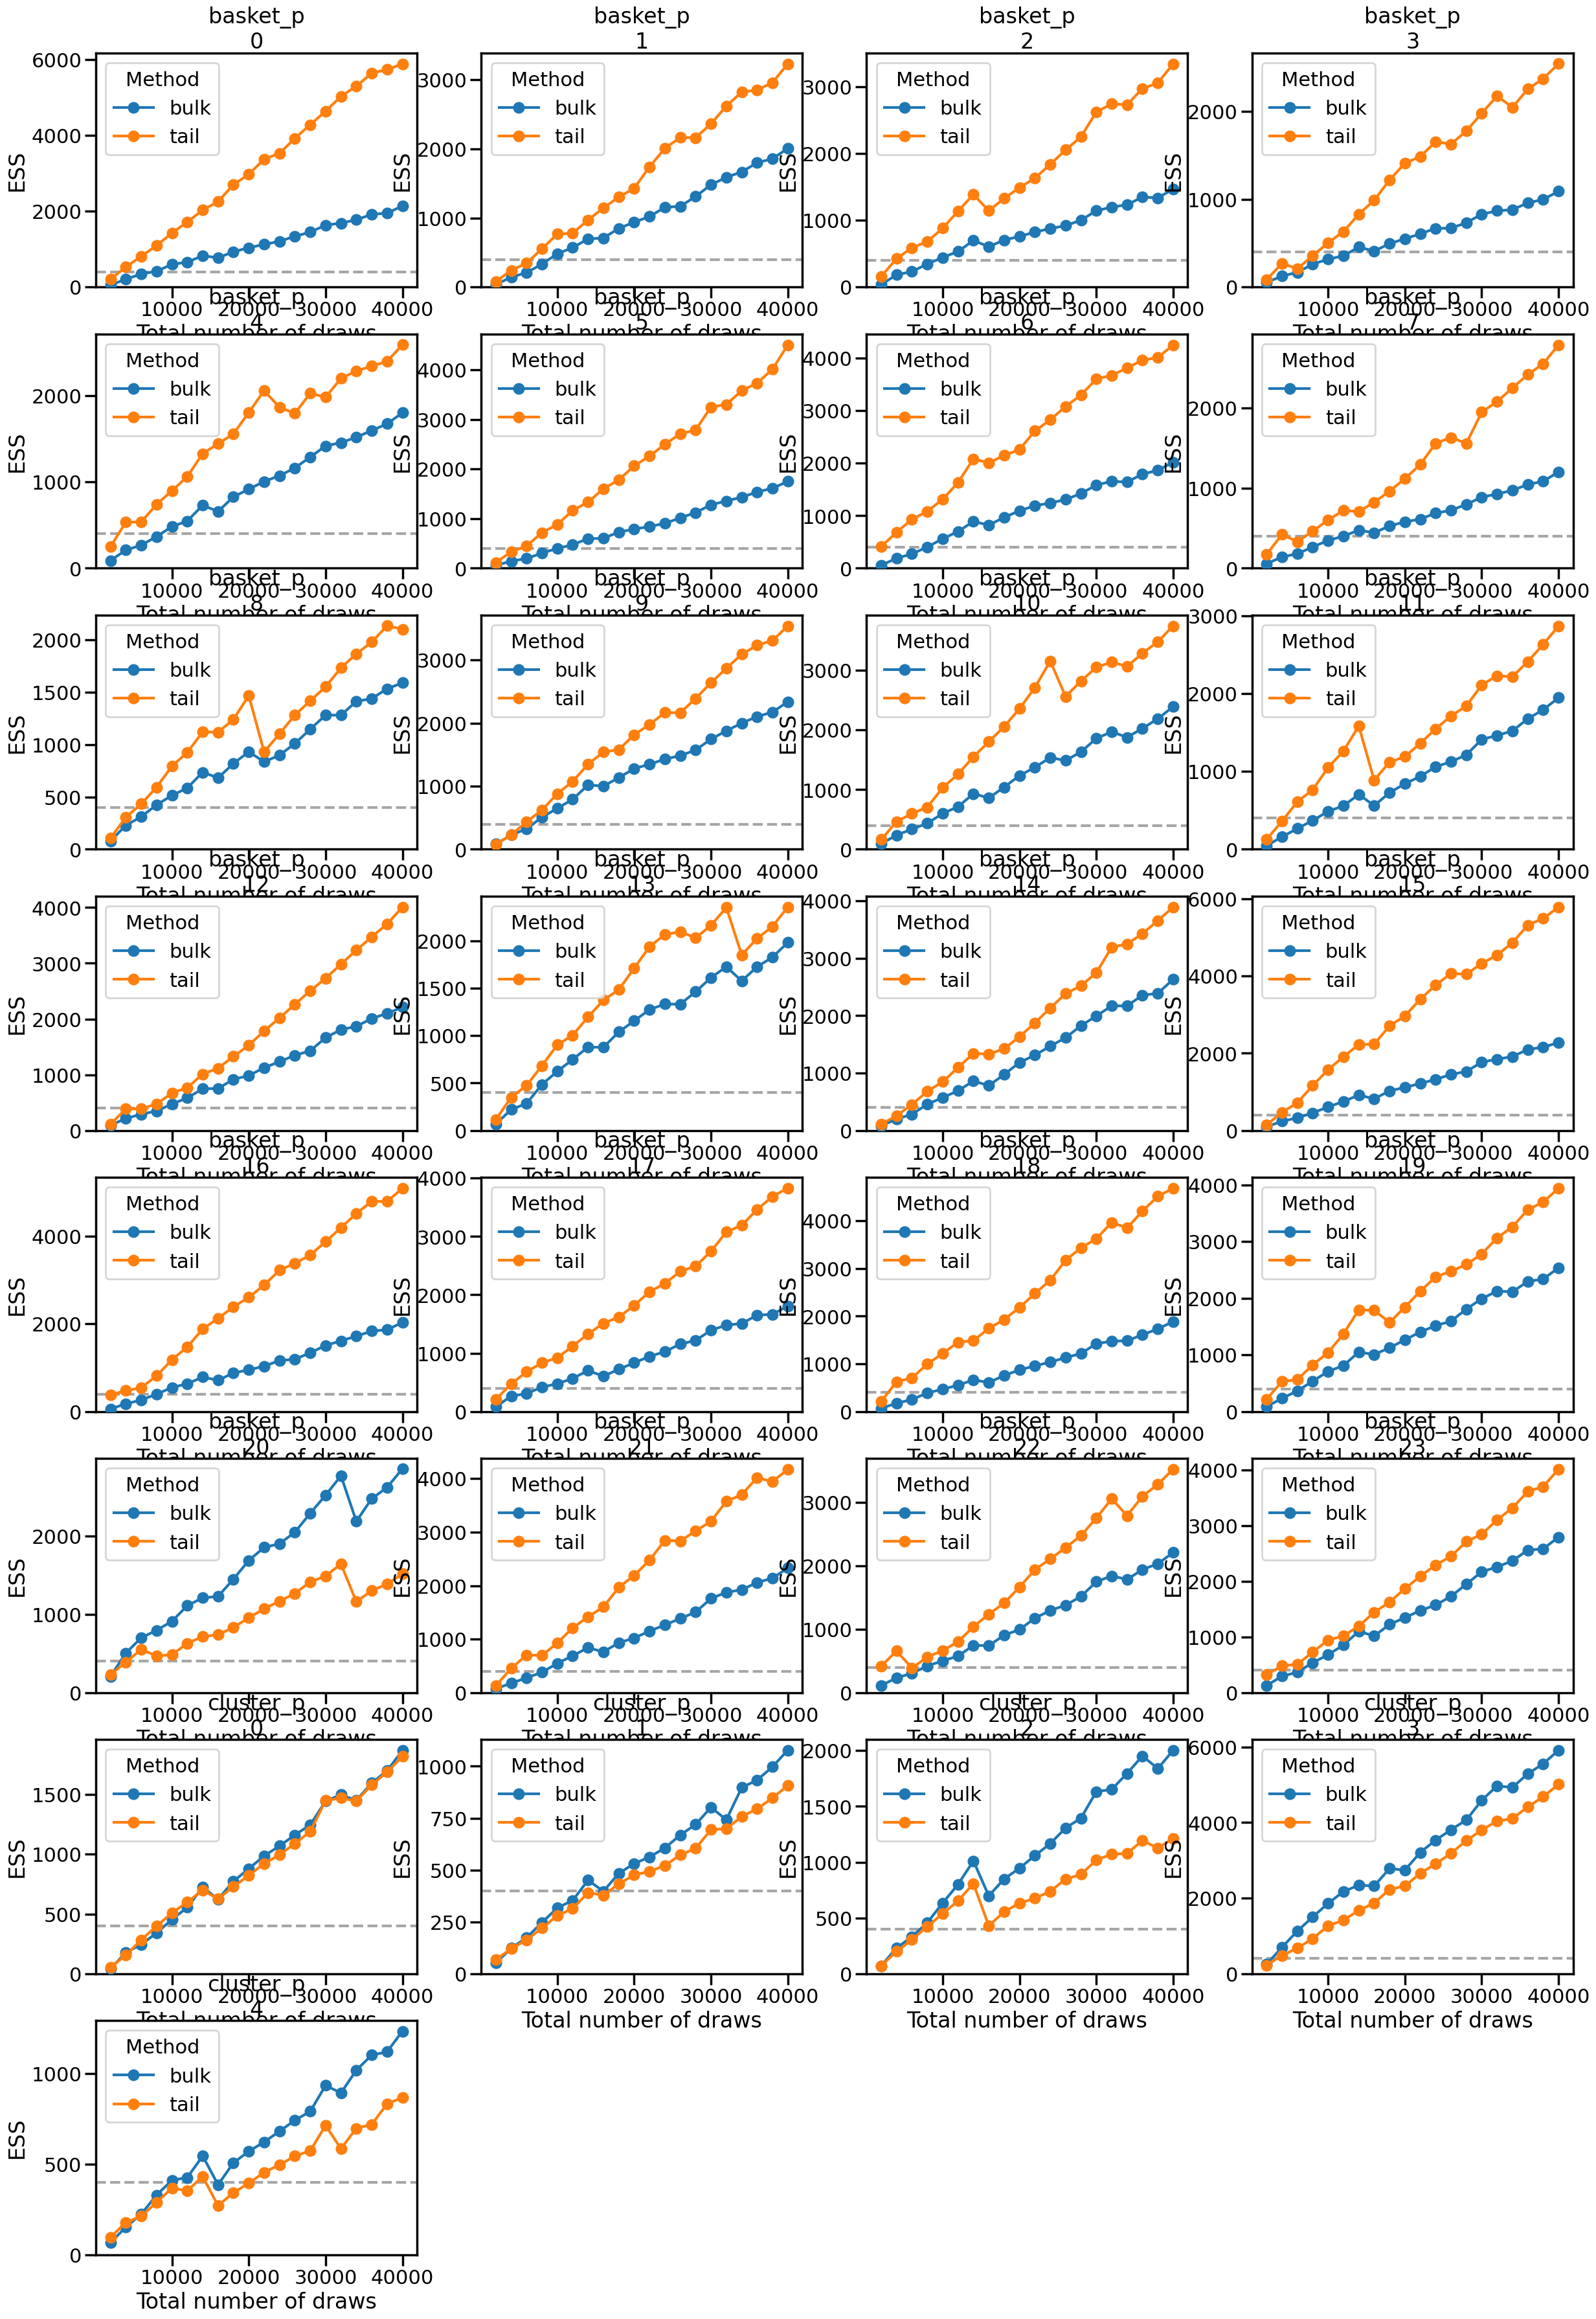

In [62]:
az.plot_ess(
    trace_h1, kind="evolution", var_names=['basket_p', 'cluster_p']
)

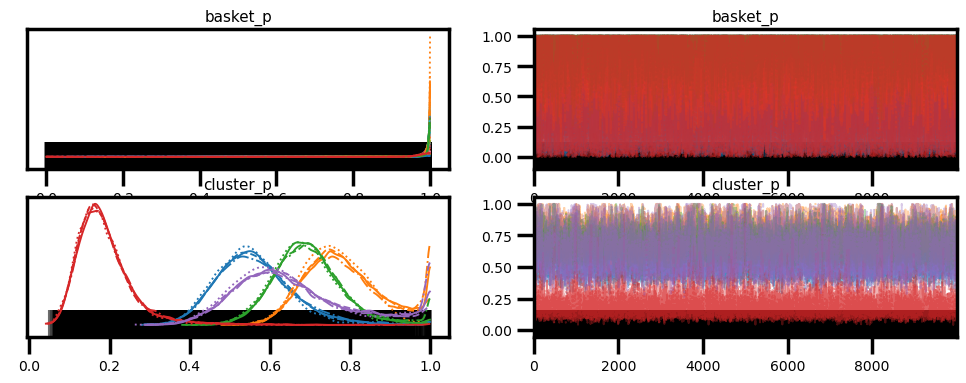

In [63]:
az.plot_trace(trace_h1, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

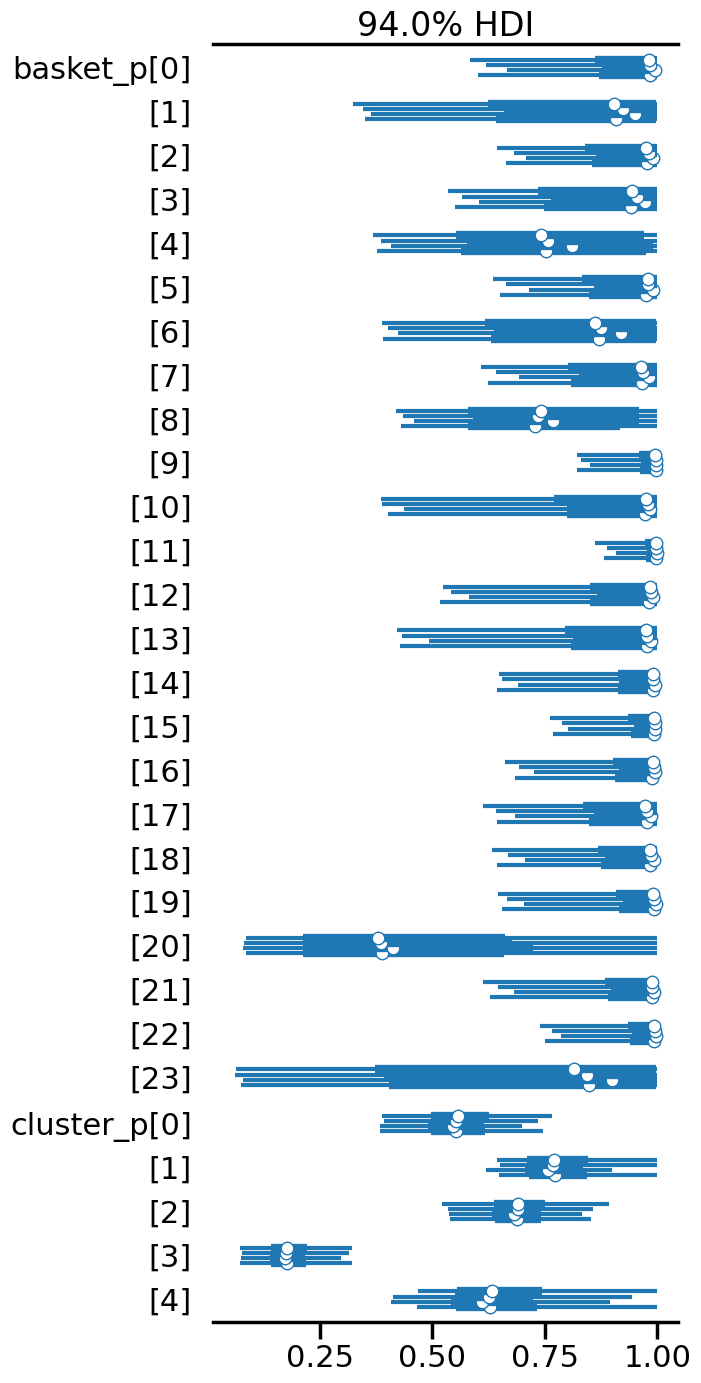

In [64]:
az.plot_forest(trace_h1, var_names=['basket_p', 'cluster_p'])

In [65]:
stacked_h1 = az.extract(trace_h1)

In [66]:
inferred_basket_p = stacked_h1.basket_p.values[:, 0]

In [67]:
inferred_cluster_p = stacked_h1.cluster_p.values[:, 0]

In [68]:
inferred_mat_h1 = np.outer(inferred_basket_p, inferred_cluster_p)

### Hierarchical model 2

Another hierarchical model, but modelling the log-odds instead.

In [69]:
model_h2 = get_patient_model_hierarchical_log_odds(patient_df)

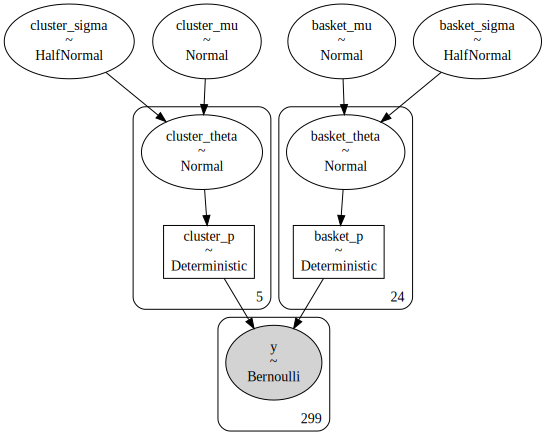

In [70]:
pm.model_to_graphviz(model_h2)

In [71]:
# with model_h2:
#     trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

This is the one we actually use after reparameterisation.

In [72]:
model_h2_nc = get_patient_model_hierarchical_log_odds_nc(patient_df)

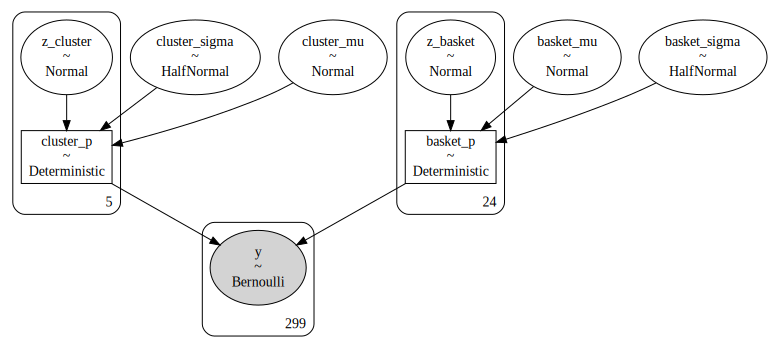

In [73]:
pm.model_to_graphviz(model_h2_nc)

In [74]:
with model_h2_nc:
    trace_h2 = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_basket, z_cluster, basket_mu, cluster_mu, basket_sigma, cluster_sigma]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 306 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6383, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [75]:
az.summary(trace_h2).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z_basket[0]   0.08  0.96   -1.81     1.82        0.0     0.01   47195.0   
z_basket[1]  -0.11  0.98   -1.98     1.69        0.0     0.01   47308.0   
z_basket[2]  -0.01  0.91   -1.76     1.67        0.0     0.00   43384.0   
z_basket[3]  -0.10  0.94   -1.80     1.74        0.0     0.00   43938.0   
z_basket[4]  -0.32  0.97   -2.06     1.57        0.0     0.00   44986.0   
...            ...   ...     ...      ...        ...      ...       ...   
cluster_p[0]  0.59  0.13    0.37     0.85        0.0     0.00   14365.0   
cluster_p[1]  0.80  0.12    0.63     1.00        0.0     0.00   13902.0   
cluster_p[2]  0.76  0.12    0.58     1.00        0.0     0.00   15261.0   
cluster_p[3]  0.22  0.08    0.10     0.37        0.0     0.00   23986.0   
cluster_p[4]  0.69  0.15    0.48     1.00        0.0     0.00   15370.0   

              ess_tail  r_hat  
z_basket[0]    24562.0    1.0  
z_basket[1]    25634.0    1.0  
z_basket[2]    24782.0    1.0  
z_basket[3]    25695.0    1.0  
z_basket[4]    25933.0    1.0  
...                ...    ...  
cluster_p[0]   10201.0    1.0  
cluster_p[1]   10916.0    1.0  
cluster_p[2]    9726.0    1.0  
cluster_p[3]   16951.0    1.0  
cluster_p[4]    9816.0    1.0  

[62 rows x 9 columns]

array([[<AxesSubplot: title={'center': 'basket_p\n0'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n1'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n2'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n3'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n4'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n5'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n6'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n7'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<AxesSubplot: title={'center': 'basket_p\n8'}, xlabel='Total number of draws', ylabel='ESS'>,
        <AxesSubplot: title={'center': 'basket_p\n9'}, xlabel='Total number of d

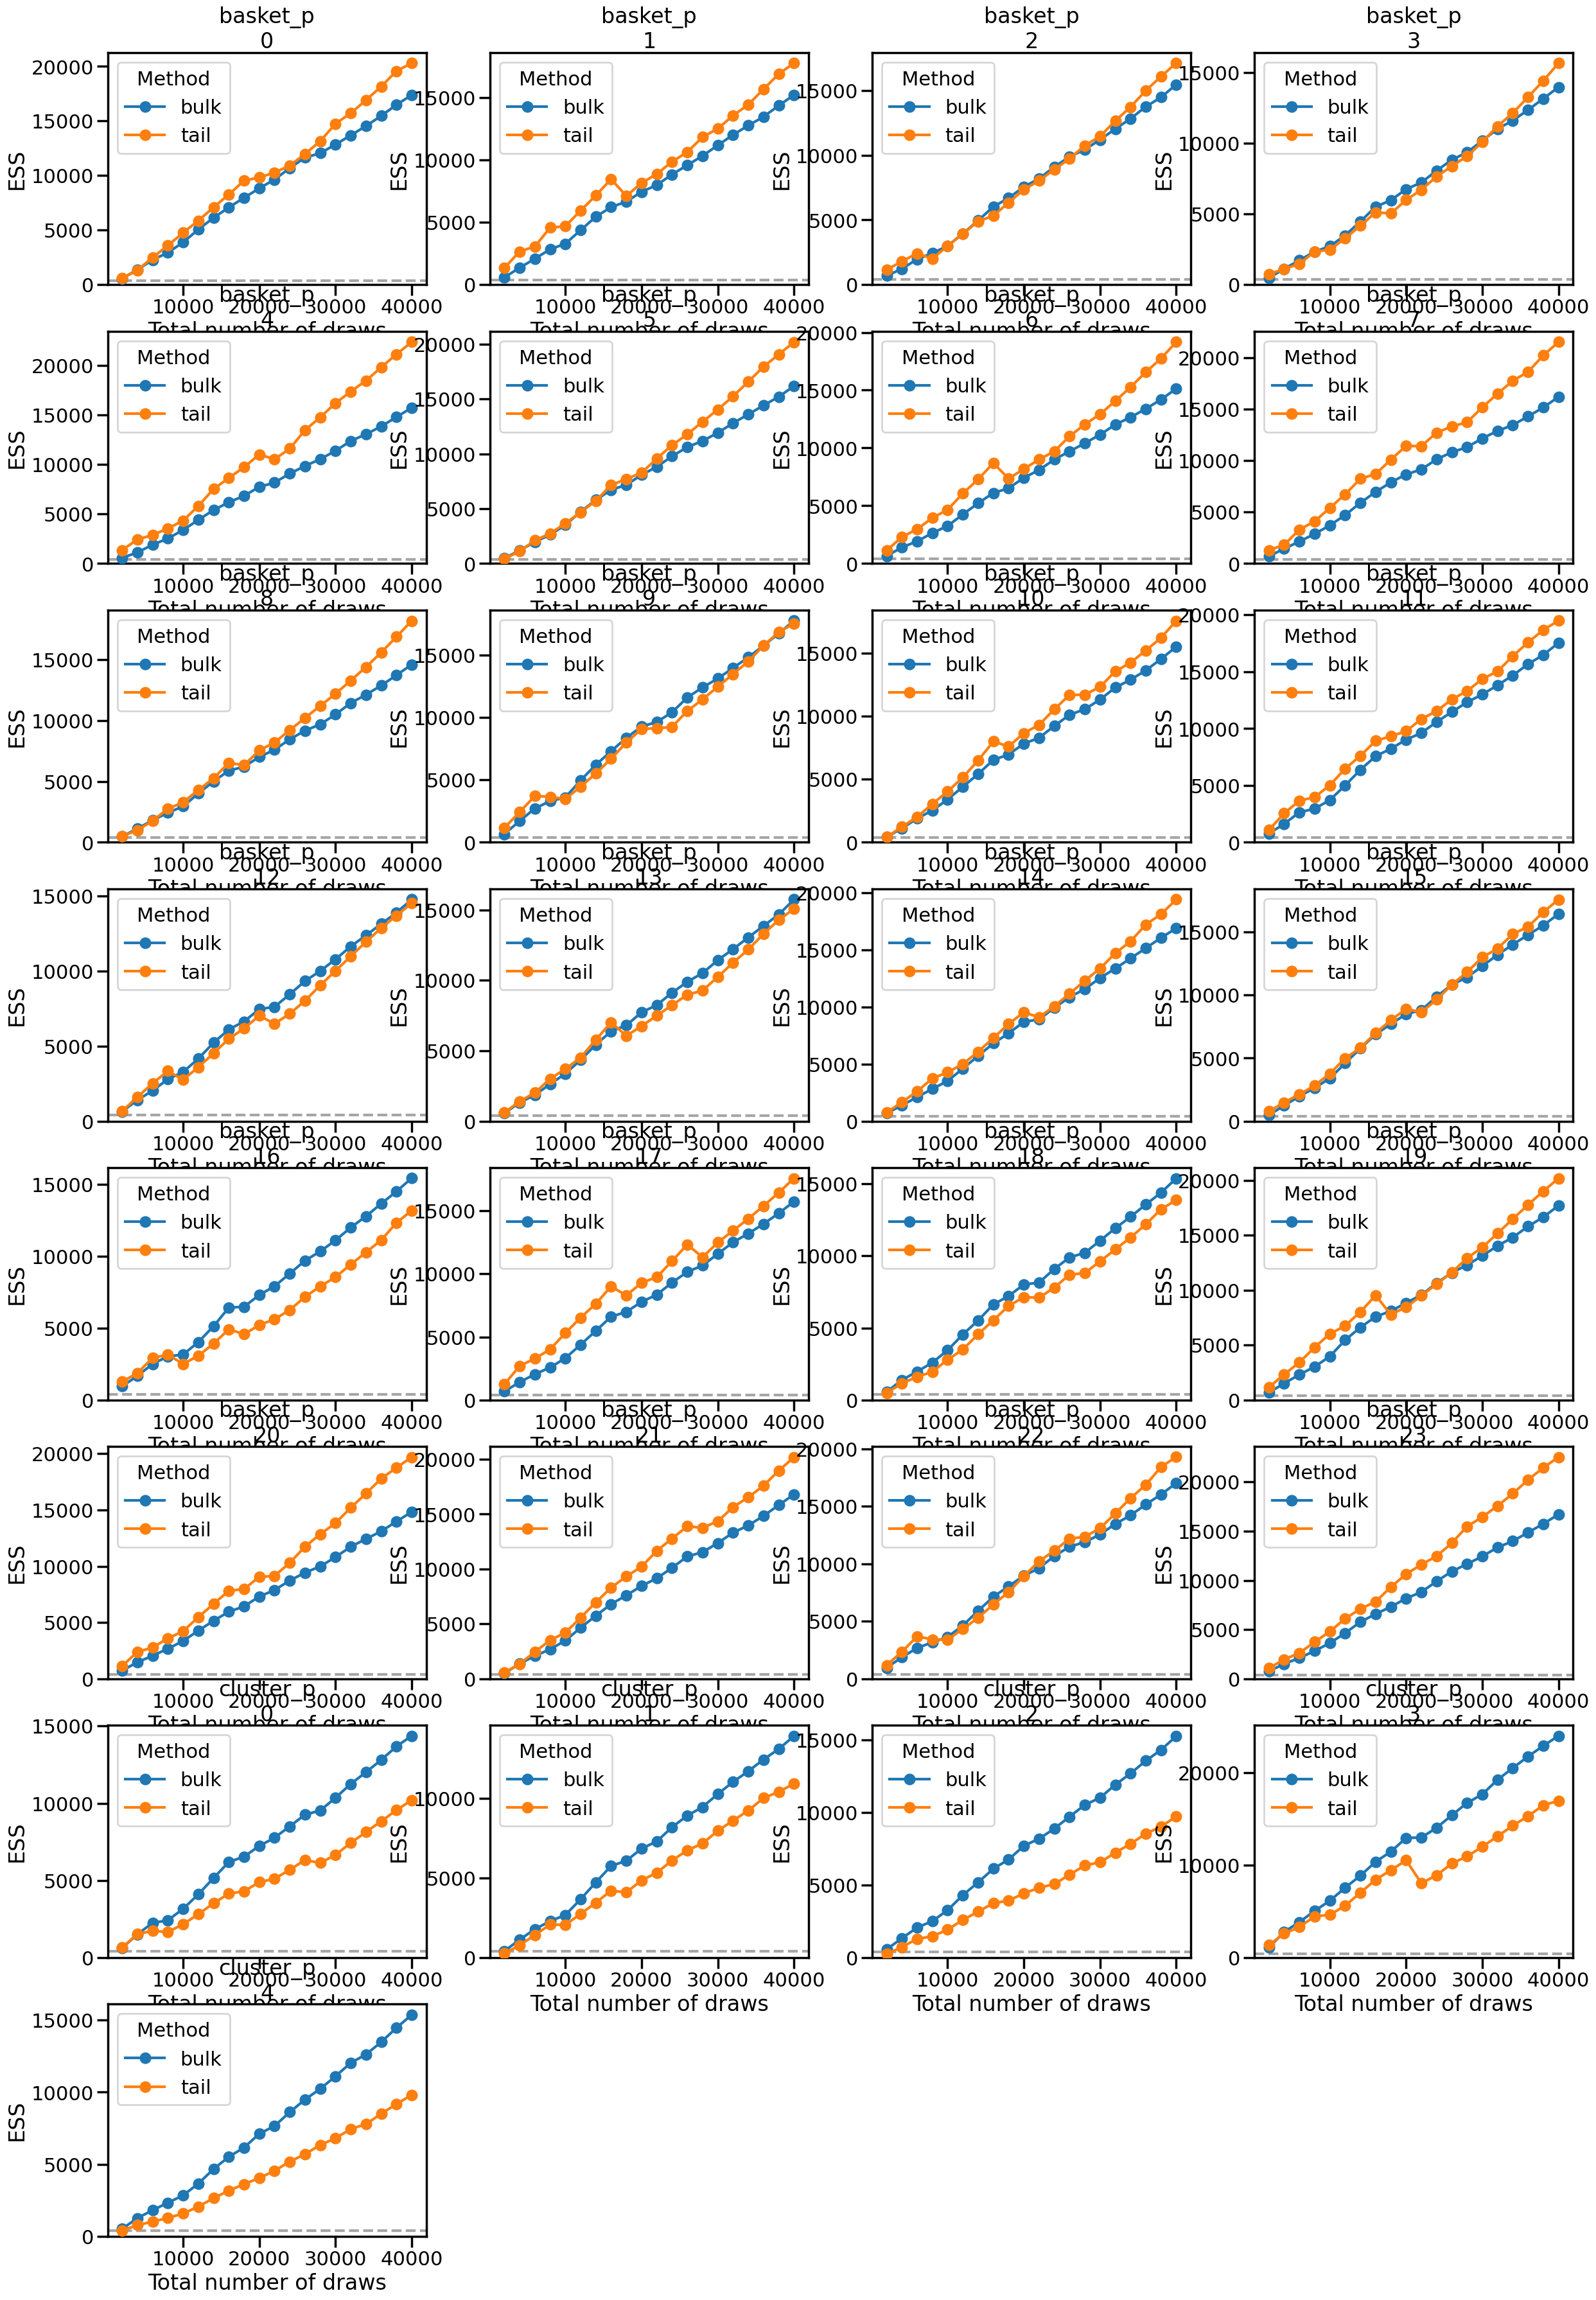

In [76]:
az.plot_ess(
    trace_h2, kind="evolution", var_names=['basket_p', 'cluster_p']
)

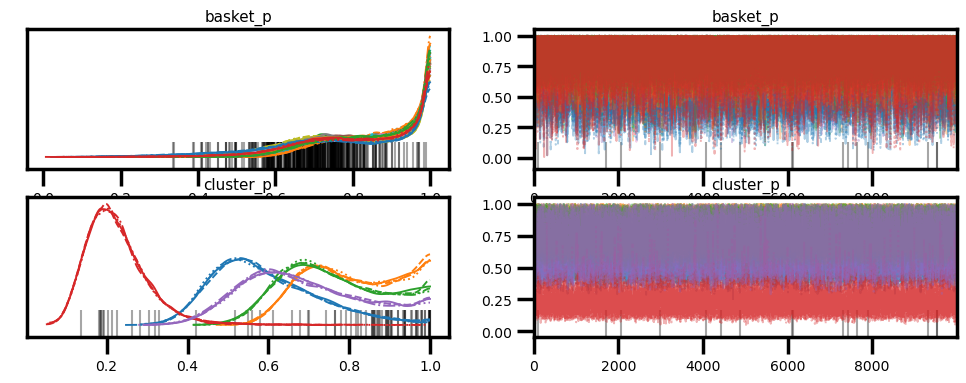

In [77]:
az.plot_trace(trace_h2, var_names=['basket_p', 'cluster_p']);

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

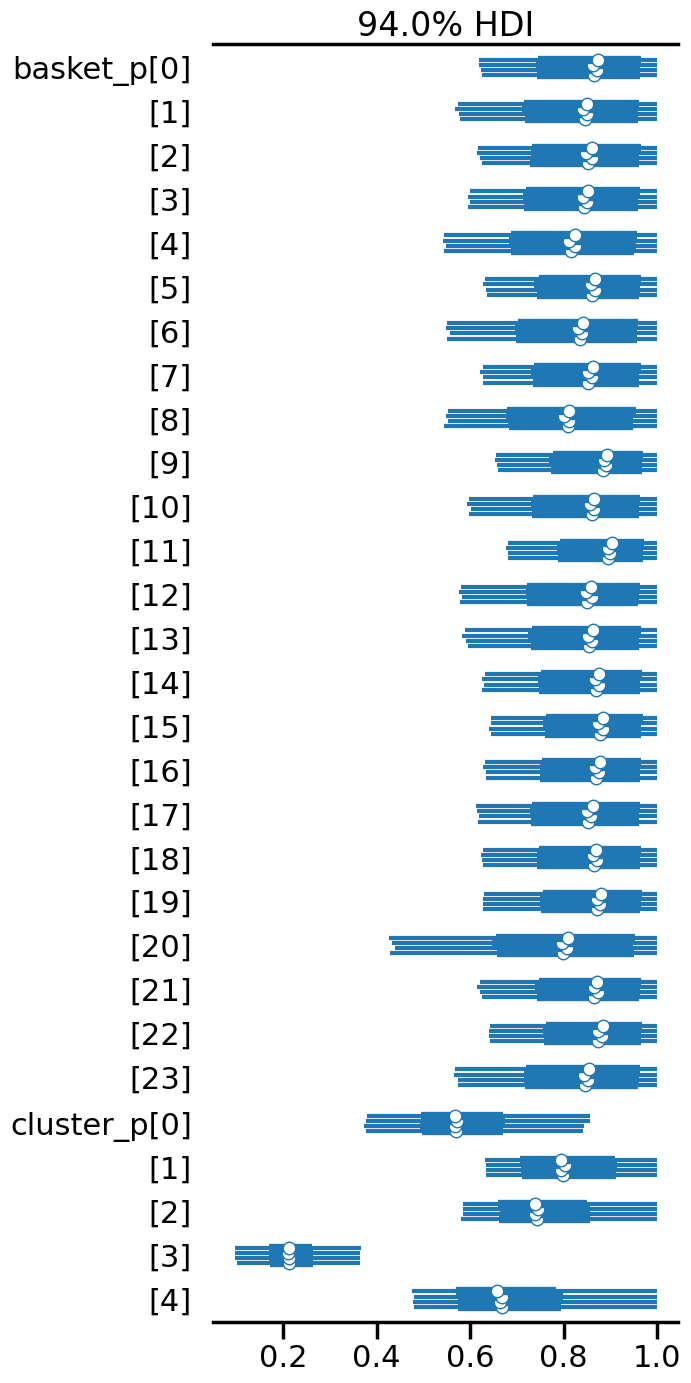

In [78]:
az.plot_forest(trace_h2, var_names=['basket_p', 'cluster_p'])

In [79]:
stacked_h2 = az.extract(trace_h2)

In [80]:
inferred_basket_p = stacked_h2.basket_p.values[:, 0]

In [81]:
inferred_cluster_p = stacked_h2.cluster_p.values[:, 0]

In [82]:
inferred_mat_h2 = np.outer(inferred_basket_p, inferred_cluster_p)

## Compare the matrices

Text(1321.8954248366013, 0.5, 'Baskets')

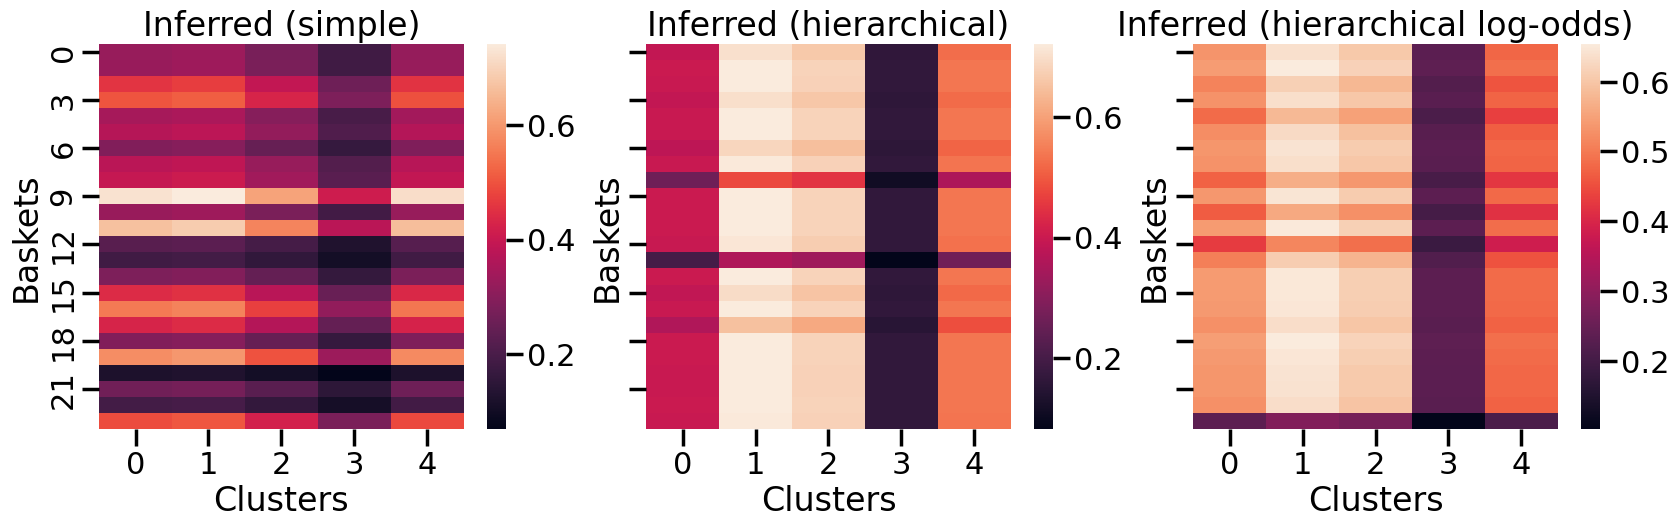

In [83]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True, sharey=True)
    
sns.heatmap(inferred_mat_s, ax=ax[0])
ax[0].set_title('Inferred (simple)')
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h1, ax=ax[1])
ax[1].set_title('Inferred (hierarchical)')
ax[1].set_xlabel('Clusters')
ax[1].set_ylabel('Baskets')
    
sns.heatmap(inferred_mat_h2, ax=ax[2])
ax[2].set_title('Inferred (hierarchical log-odds)')
ax[2].set_xlabel('Clusters')
ax[2].set_ylabel('Baskets')

## Model comparison

In [84]:
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning, module="arviz.stats.stats")

In [85]:
loo_s = az.loo(trace_s)
loo_s

Computed from 40000 posterior samples and 299 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -200.31     6.44
p_loo       13.79        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      299  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [86]:
loo_h1 = az.loo(trace_h1)
loo_h1

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:1037: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 40000 posterior samples and 299 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -189.53     6.95
p_loo       14.15        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      293   98.0%
 (0.5, 0.7]   (ok)          6    2.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [87]:
loo_h2 = az.loo(trace_h2)
loo_h2

Computed from 40000 posterior samples and 299 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -187.55     6.07
p_loo        7.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      299  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [88]:
ic = 'loo'
df_comp_loo = az.compare({
    's': loo_s, 
    'h1': loo_h1,
    'h2': loo_h2,    
}, ic=ic)
df_comp_loo

rank    elpd_loo      p_loo  elpd_diff        weight        se       dse  \
h2     0 -187.549058   7.086380   0.000000  1.000000e+00  6.068282  0.000000   
h1     1 -189.531754  14.148529   1.982696  0.000000e+00  6.954800  1.969237   
s      2 -200.314526  13.792902  12.765468  4.056755e-13  6.443863  5.013522   

    warning scale  
h2    False   log  
h1    False   log  
s     False   log

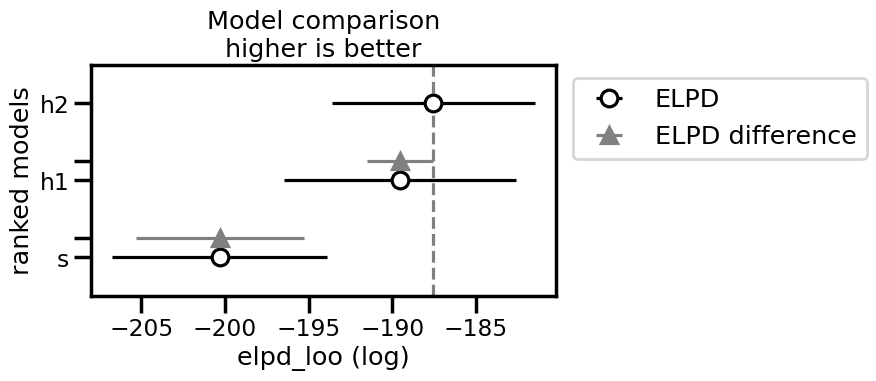

In [89]:
az.plot_compare(df_comp_loo);

# Save results

Save all the results to check in another notebook.

In [90]:
expr_df_filtered.shape, expr_df_selected.shape, len(class_labels), len(cluster_labels), patient_df.shape

((299, 19957), (299, 500), 299, 299, (299, 5))

In [91]:
drug_name, C

('Bortezomib', 5)

In [92]:
save_data = {
    'expr_df_filtered': expr_df_filtered,
    'expr_df_selected': expr_df_selected,
    'class_labels': class_labels,
    'cluster_labels': cluster_labels,
    'patient_df': patient_df
}
save_obj(save_data, os.path.join('results', 'patient_analysis_%s_cluster_%d.p' % (drug_name, C)))

2023-03-01 16:09:13.594 | INFO     | pyBasket.common:save_obj:62 - Saving <class 'dict'> to results/patient_analysis_Bortezomib_cluster_5.p


In [93]:
patient_df.to_csv(os.path.join('results', 'patient_analysis_%s_cluster_%d.csv' % (drug_name, C)))